# General Understanding

The United States constitution requires a decennial census.   The census provides a headcount which does not provide enough details to make data driven decisions about the distribution of government funds.  A long form census with necessary details was introduced in the 20th century.   Only one in six households received the additional questions on the long form.  In the 21st century, the American Community Survey (ACS) was established to conduct ongoing surveys with the details previously included on the decennial long form census.   The ACS survey results provide data to determine the appropriate distribution of more than $400 billion in federal and state funds.  The funds are for social programs as well as physical and service infrastructure.  Annually 3.5 million homes are surveyed for the ACS.   

The attributes from the personal data allow for exploration of the correlation between select attributes and the total income. 


Source: https://www.census.gov/programs-surveys/acs/
        https://www.kaggle.com/census/2013-american-community-survey

# Data Description

Data from the 2013 ACS is available.  The data is segmented into housing data which applies to the entire household and personal data which provides detailed data for all individuals living in the household surveyed.  The household and personal data are independent.   No attempt was made to consolidate the files on this exploration of the data.   

Due to the size of the files and the number of attributes, the focus was on the 2.5% random sample of the personal data.  The personal data sample contains over seventy thousand (78,320) records with 283 attributes.  The descriptions of all attributes is contained in the data dictionary from the US Census Bureau.

Data Dictionary:  https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt

For the exploratory analysis, all children were omitted from the data.  The question was the factors influencing poverty and income.  Any inferences would be limited to the sample population and would not be causal inferences.


### Data Descriptions
Several key variables were included in the exploratory analysis.  The following lists the attributes used for the data exploration.    

Attributes used for data exploration and visualization:
  * AGEP:  Age of person (continuous 0-95)
  * CIT:  Citizenship status (categorical - numerical key)
  * CIT_CAT:  Citizenship status (categorical - string)
  * COW:  Class of worker (categorical - string)
  * ENG:  Ability to speak English (categorical scale of 1-4 and native speakers)
  * JWMNP:  Travel time to work (continuous - minutes of commute to work)
  * JWTR:  Means of transportation to work (categorical - 12 modes of transportation)
  * MAR:  Marital status (categorical - 5 categories: married, divorced, separated, single, widow)
  * OC_CAT:  Own child (Boolean)
  * PAP:  Public assistance income past 12 months (continuous variable of dollars of assistance received)
  * PINCP:  Total person's income (continuous of total income)
  * POVPIP:  Income-to-poverty ratio recode (continuous with a cap at 501)
  * PUMA:  Public use microdata area code (PUMA) based on 2010 Census  (provides geographic data of individual location)
  * RAC1P:  Recoded detailed race code (categorical - 9 categories including 7 primary categories and 2 miscellaneous categories)
  * SCHL:  Educational attainment (continuous - years of completed education)
  * SEX:  Sex (gender of female or male)
  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', DeprecationWarning)

# Data Quality

The original dataset contained approximately 3.1 million records. We quickly found that using the entire dataset would be much too arduous on our computers and would take too much time to gain meaningful information from the data.

We chose to take a subset of this dataset by randomly choosing 2.5% of the rows (approximate 78,000 observations) from the original dataset. We recognize that there will be some loss in the interpretability of any statistical observations we make on this subset. The following is the R code which we used:

```R
set.seed(5)
# take person data
person_raw_a = read.csv('../data/ss13pusa.csv')
person_raw_b = read.csv('../data/ss13pusb.csv')
person_full = rbind(person_raw_a, person_raw_b)

numberRowsToRetrieve = round(nrow(person_full)*.025) # 2.5 percent ~78k rows
random.sample = person_full[sample(1:nrow(person_full), numberRowsToRetrieve, replace=FALSE),]

write.csv(random.sample, '../data/person-subset-2.5percent.csv')
```

Now with our dataset created, we can load it:

In [2]:
person_raw = pd.read_csv('../data/person-subset-2.5percent.csv')

We take only the variables we plan on using:

In [3]:
important_continuous_features = [
    'PINCP',    # Total person's income (signed)
    'POVPIP',   # Income-to-poverty ratio recode (continuous)
    'JWMNP',    # Travel time to work (continuous)
    'AGEP',     # Age of person (continuous 0-95)
    'PWGTP',    # Person's weight (continuous)
    'PAP',      # Public assistance income in past 12 months
]

importegorical_features = [
    'CIT',  # Citizenship status (categorical - string)
    'OC',   # Own child (Boolean)
    'ENG',  # Ability to speak English (ordinal 1-4)
    'COW',      # Class of worker (categorical - string)
    'PUMA',     # Public use microdata area code (PUMA) based on 2010 Census definition
    'SEX',      # Gender
]

important_features = important_continuous_features + importegorical_features;

df = person_raw[important_features]

This dataset includes records for various ages, including children. Because children do not make an income, we can safely remove them from our dataset

In [4]:
df = df[df.AGEP > 18]

The dataset includes only numeric variables, but several of these variables represent categorical variables. We edit these variables and provide new, meaningful, factoral levels.

In [5]:
df['CIT'] = df.CIT.astype('category').astype('str')
df.CIT = df.CIT \
    .replace('1', 'US Born') \
    .replace('2', 'US Territory Born') \
    .replace('3', 'Born Abroad)') \
    .replace('4', 'Naturalized') \
    .replace('5', 'Non-Citizen')

df['OC'] = df.OC.astype('category').astype(bool)

df['ENG'] = df.ENG.astype('category').astype('str')
df.ENG = df.ENG \
    .replace('nan', 'Speaks only English') \
    .replace('1.0', 'Very well') \
    .replace('2.0', 'Well') \
    .replace('3.0', 'Not well') \
    .replace('4.0', 'Not at all')

df['COW'] = df.COW.astype('category').astype('str')
df.COW = df.COW \
    .replace('b', 'child') \
    .replace('1.0', 'Private for Profit') \
    .replace('2.0', 'Private Non-Profit') \
    .replace('3.0', 'Local Government') \
    .replace('4.0', 'State Government') \
    .replace('5.0', 'Federal Government') \
    .replace('6.0', 'Self Employed (not incorportated)') \
    .replace('7.0', 'Self Employed (incorporated)') \
    .replace('8.0', 'Family Business - no pay') \
    .replace('9.0', 'Unemployeed')

df['SEX'] = df.SEX.astype('category').astype('str')
df.SEX = df.SEX \
    .replace('1', 'Male') \
    .replace('2', 'Female')

Now, with our new categorical variables, we can see if we are missing any values.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 78317
Data columns (total 12 columns):
PINCP     60357 non-null float64
POVPIP    57892 non-null float64
JWMNP     32486 non-null float64
AGEP      60357 non-null int64
PWGTP     60357 non-null int64
PAP       60357 non-null float64
CIT       60357 non-null object
OC        60357 non-null bool
ENG       60357 non-null object
COW       60357 non-null object
PUMA      60357 non-null int64
SEX       60357 non-null object
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 5.6+ MB


As we can see, all of the variables we are looking at appear to have a complete response. Only two variables seem to be missing values: `JWMNP` (missing 46%) `POVPIP` (missing 5%).

We will proceed with caution when proividing analysis based on these two variables. Eventually, we may decide to impute the data based on a linear regression for these continuous variables or perhaps another technique.

# Summary Statistics

### Summary Statistics for continuous variables

In [7]:
df[important_continuous_features].describe().astype('int64')

,PINCP,POVPIP,JWMNP,AGEP,PWGTP,PAP
count,60357,57892,32486,60357,60357,60357
mean,38326,315,26,49,99,50
std,54908,164,22,18,80,661
min,-12200,0,1,19,1,0
25%,9000,171,10,34,52,0
50%,24000,325,20,50,77,0
75%,49000,501,30,63,120,0
max,1027000,501,167,95,1505,30000


# Summary Statistics for categorical variables

In [8]:
df[importegorical_features].describe()

,PUMA
count,60357.000000
mean,4557.932435
std,9227.228315
min,100.000000
25%,824.000000
50%,2102.000000
75%,4016.000000
max,70301.000000


# Visualization

#### Histogram of Income

Here we explore some of the features which we hope to use for future analysis. First we explor our variable for income PINCP using a histogram. As we can tell, the distribution is very right skewed.

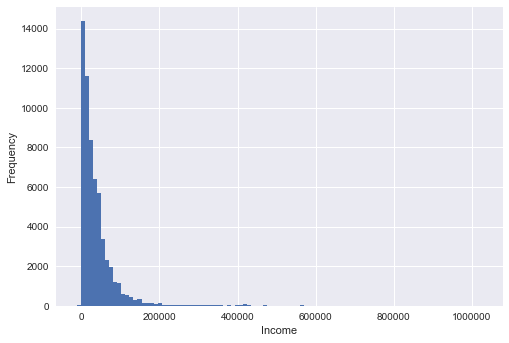

In [9]:
plt.xlabel('Income')
df.PINCP.plot.hist(bins=100)
plt.show()

#### Histogram of Income

Looking at a more detailed view of just income that is less than $150,000, we see what appears to be a peak somewhere around $10,000. Additionally, we see a huge number of of responses who claim to bring in an income of $0. Additional analysis be used to determine if these individuals have supplemted earnings from another source.

Next we take a look at the distribution of the person's age. It appears that the distribution is fairly uniform. We can see that there is a spike in responses from the baby boomers. Response frequencies tend to trail off after age 65 or so. Strangely, there is spike around age 92. Additional analysis should be done to determine if this spike is in  error.

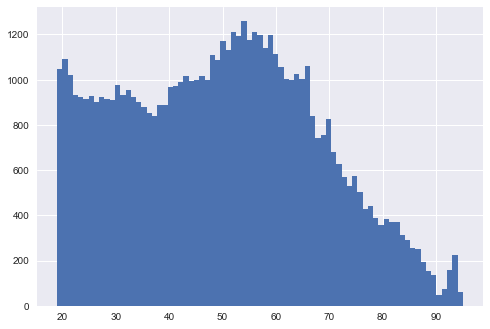

In [10]:
df.AGEP.hist(bins=len(df.AGEP.unique()))
plt.show()

#### Histogram of Commute Time

Next, we look at commute time (`JWMNP`). Although one would expect this to be continuous, we find that there are many spikes in the datset.

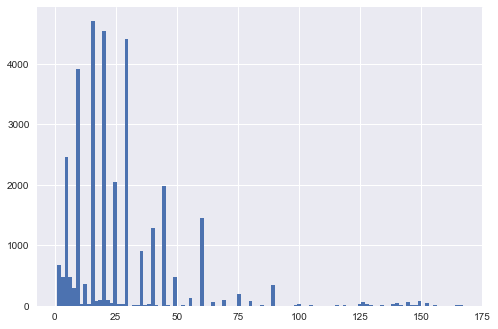

In [11]:
df.JWMNP.hist(bins=len(df.JWMNP.unique()))
plt.show()

#### Histogram of Commute Time

Further analysis into cummute time, we can determine that these large spikes can be attributed to such approximations which are common when describing time in minutes:

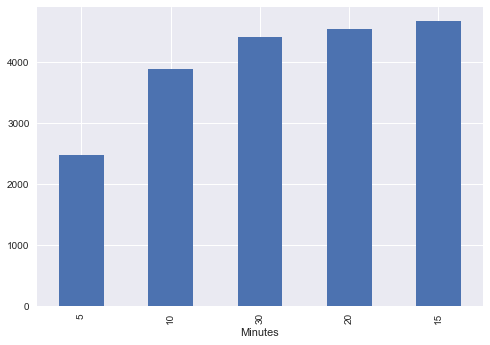

In [12]:
ax = df.JWMNP[df.JWMNP.notnull()].astype('int64').value_counts() \
    .sort_values().tail().plot(kind='bar')
ax.set_xlabel('Minutes')
plt.show()

# Explore Relationships Between Variables

At a high level, we explore all of the continuous variables in a scatterplot matrix. Unfortunately, there does not seem to be much obvious linearity between the features. There are, however, many outliers and skewed data that we should be aware of.

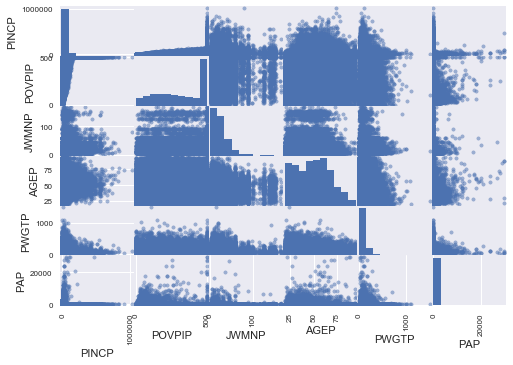

In [13]:
scatter_matrix(df[important_continuous_features])
plt.show()

#### Relationship of Income and Person's Weight

One interesting comparison is between income and a person's weight (in pounds). Indeed, the densist grouping of individuals, whose reported income is greater than 150,000, also claim to way less than 200 pounds. Some very unlucky individual appears to weigh 1505 pounds.

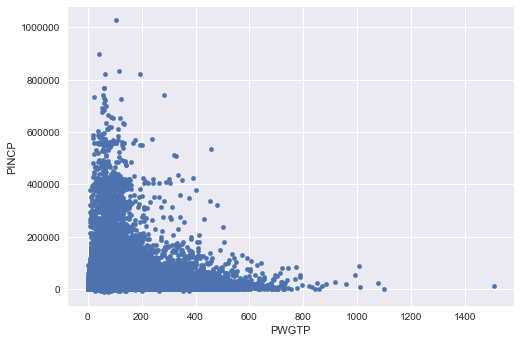

In [14]:
df.plot.scatter(x='PWGTP', y='PINCP')
plt.show()

#### Relationship of Income and Citizen Status

When comparing income versus citizen status (`CIT`), we do see the largest difference, in the violin plots, for non-citizens (taking subset of people with income < $150,000).

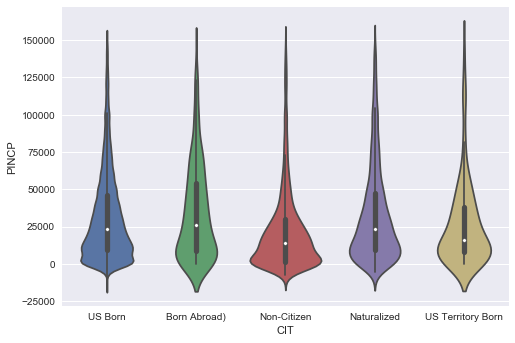

In [15]:
sns.violinplot(x="CIT", y="PINCP", data=df[df.PINCP < 150000])
plt.show()

#### Relationship of Income and Age

When we compare income versus age (`AGEP`), we see what appears to be a parabolic relationship between age and income. The highest density of high-income earners tends to come from people between ages 40-70. Again, we see the strange spike around age 92. Further evidence that something might be a bit off.

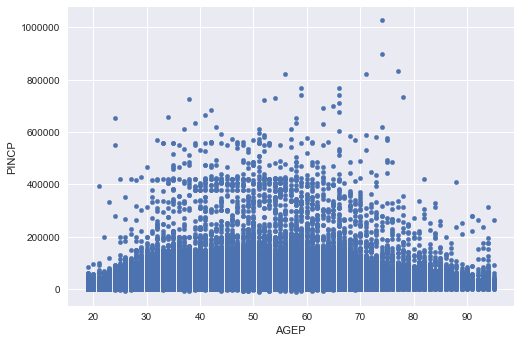

In [16]:
df.plot.scatter(x='AGEP', y='PINCP')
plt.show()

#### Relationship of Income and Proficiency of English

Taking a subset of the data, for when income is less than $150K, and looking at the proficiency of English versus a person's income, we can actually gain some decent incite into the stubbed distribution which comes from not knowing English at all.

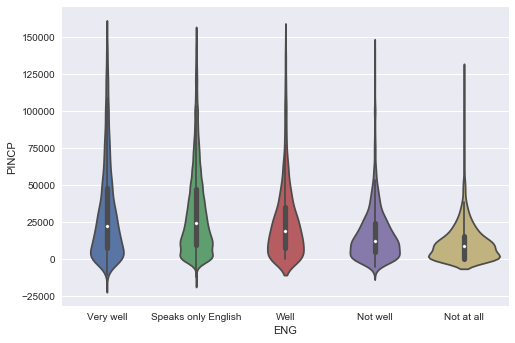

In [17]:
sns.violinplot(x="ENG", y="PINCP", data=df[df.PINCP < 150000]) 
plt.show()

### Relationships between attributes
The focus of data exploration was on the effects of various attributes on income and poverty.   

#### Relationship between travel time to work in total income:
The correlation between the travel time and the total income was not as expected.  The expectation was that longer travel times would be for higher paying employment.  One possibility to explore is the travel times may be longer in the rural areas where wages are traditionally lower as in the cost of living. 

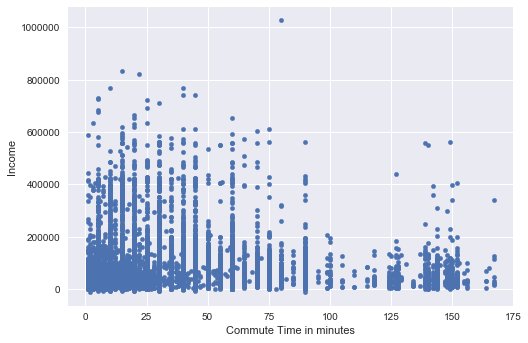

In [18]:
### Scatterplot of Income and commute time
df.plot.scatter(x='JWMNP', y='PINCP')
plt.xlabel('Commute Time in minutes')
plt.ylabel('Income')
plt.show()

#### Relationship of Income and Sex

Next we examine gender (`SEX`) versus income. A few interesting observations can be made. First off, it appears that the _individuals_ with highest income are female. Secondly, it apepars that all summary statistics (median, IQR, etc) give higher income to male individuals as a whole.

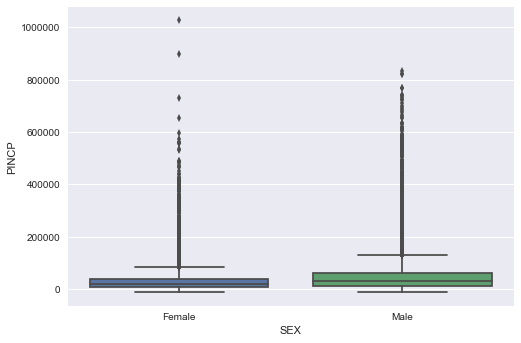

In [19]:
sns.boxplot('SEX', 'PINCP', data=df)
plt.show()

### Additional Features
As mentioned in the introduction, other attributes may be considered in the analysis of the data.   Included in the personal data are military history, disabilities, race, and ancestry.   In the associated housing file, attributes about housing details, expenses of the household, and internet access are included.  Due to the one to many relationship from the housing data to the personal data, no attempt was made to combine the data at this time.

Examples of additional attributes that may be explored within the personal dataset:
    * Disabilities: Includes a variety of disability indicators such as vision, hearing, cognitive, and self-care.
    * Military Service: Includes era of service, duration of service, and disability from service.
    * Ancestry:  Includes more specific details on race as well as country of origin for ancestry.
    * Family unit:  Includes details about multigenerational homes and the responsibility of grandparents caring for grandchildren.
    * Insurance:  Includes the source of the insurance.

Examples of attributes from the housing data:
    * Home features:  Includes bathrooms, bedrooms, running water, and other home features.
    * Internet access types.
    * Home expenses:  Includes utilities, rent, and mortgages.

### Exceptional Work

Here, we use an example from Kaggle, https://www.kaggle.com/pjbutcher/making-a-map/code, to compare average income between various regions (a region is known as a `PUMA`).

#### Setup

In [20]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle('Comparison of Region Incomes', fontsize=20)


# create a map object with the Albert Equal Areas projection.
# This projection tends to look nice for the contiguous us.
m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='aea',\
            lat_1=30.,lat_2=50,lon_0=-96,lat_0=38)
            
# state codes from http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt
# note that areas outside of the conus have been commented out
state_codes = {
    '01': 'Alabama',
    #   '02': 'Alaska',
    '04': 'Arizona',
    '05': 'Arkansas',
    '06': 'California',
    '08': 'Colorado',
    '09': 'Connecticut',
    '10': 'Delaware',
    '11': 'District of Columbia',
    '12': 'Florida',
    '13': 'Georgia',
    '15': 'Hawaii',
    '16': 'Idaho',
    '17': 'Illinois',
    '18': 'Indiana',
    '19': 'Iowa',
    '20': 'Kansas',
    '21': 'Kentucky',
    '22': 'Louisiana',
    '23': 'Maine',
    '24': 'Maryland',
    '25': 'Massachusetts',
    '26': 'Michigan',
    '27': 'Minnesota',
    '28': 'Mississippi',
    '29': 'Missouri',
    '30': 'Montana',
    '31': 'Nebraska',
    '32': 'Nevada',
    '33': 'New Hampshire',
    '34': 'New Jersey',
    '35': 'New Mexico',
    '36': 'New York',
    '37': 'North Carolina',
    '38': 'North Dakota',
    '39': 'Ohio',
    '40': 'Oklahoma',
    '41': 'Oregon',
    '42': 'Pennsylvania',
    '44': 'Rhode Island',
    '45': 'South Carolina',
    '46': 'South Dakota',
    '47': 'Tennessee',
    '48': 'Texas',
    '49': 'Utah',
    '50': 'Vermont',
    '51': 'Virginia',
    '53': 'Washington',
    '54': 'West Virginia',
    '55': 'Wisconsin',
    '56': 'Wyoming',
    #   '72': 'Puerto Rico'
}

# define a colorramp
num_colors = 15
cm = plt.get_cmap('Blues')
blues = [cm(1.*i/num_colors) for i in range(num_colors)]

# add colorbar legend
cmap = mpl.colors.ListedColormap(blues)
# define the bins
bounds = np.linspace(0.0, 1.0, num_colors)

/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


#### Calculate average incomes

In [21]:
# All the income stuff
df['logPINCP'] = np.log(df.PINCP+(-1*df.PINCP.min())+1)
df['PCNIProlog'] = df['logPINCP'].fillna(0).astype(np.int64)


#grab PUMA
puma = df.groupby(['PUMA'])

puma_means = puma.PCNIProlog.mean()
puma_clean = puma_means.subtract(puma_means.min())
puma_means_range = puma_clean.div(puma_clean.max())
puma_color_index = puma_means_range.multiply(1.4).multiply(10).astype('int64')

#### Create Map

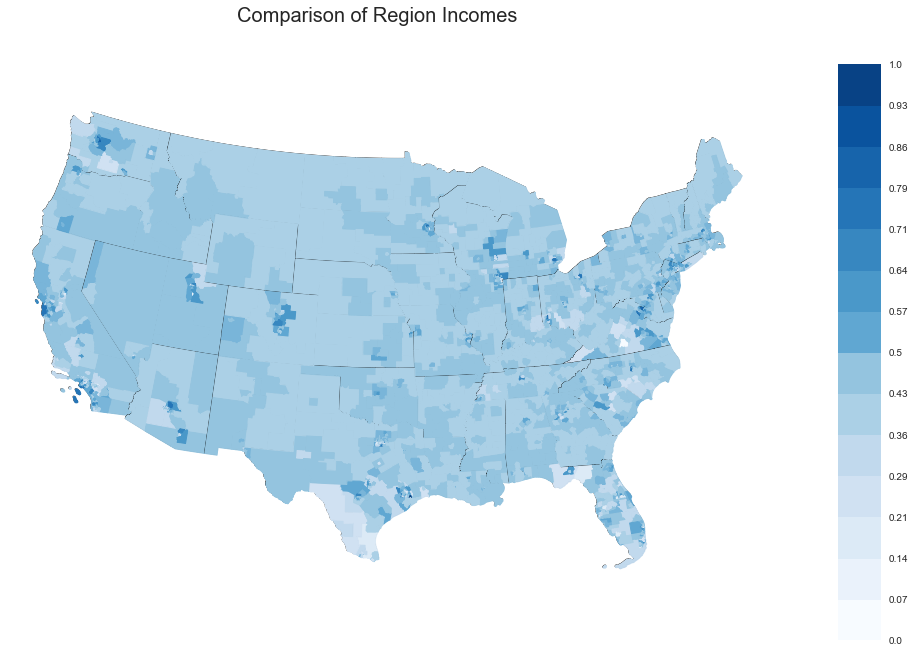

In [22]:
# read each states shapefile
for key in state_codes.keys():
    m.readshapefile('../data/shapefiles/tl_2013_{0}_puma10'.format(key),
                    name='state', drawbounds=True, default_encoding='latin-1')
                    
    # loop through each PUMA and assign a random color from our colorramp
    for info, shape in zip(m.state_info, m.state):
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches, edgecolor='k', linewidths=1., zorder=2)
        try:
            color_index = puma_color_index[int(info['PUMACE10'])]
            color = blues[color_index]
        except IndexError:
            # print 'not found %d' % int(info['PUMACE10'])
            color = blues[0]
        pc.set_color(color)
        ax.add_collection(pc)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=bounds, boundaries=bounds,
                               format='%1i')
cb.ax.set_yticklabels([str(round(i, 2)) for i in bounds])

plt.show()